In [58]:
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric import transforms
from torch_geometric.nn import GAE
from torch_geometric.utils.convert import from_networkx, to_networkx
from matplotlib import pyplot as plt
import time

In [2]:
#from main_util_func import *

In [3]:
def data_load(embed, size):
    embed_size = size
    node_data_loc = '../new_data/mgpnodeList_with_year_completion.csv'
    edge_data_loc = '../new_data/mgpedgeList_wodup.csv'
    nodes = pd.read_csv(node_data_loc, sep=',', lineterminator="\n", low_memory=False)
    nodes['Year'] = pd.to_datetime(nodes['Year'],format='%Y',errors='ignore')
    nodes['Year'] = nodes['Year'].astype(float)
    nodes["sci_embed"] = nodes["Id"].map(embed)
    
    nodes["sci_embed"] = nodes["sci_embed"].apply(lambda x: [np.float16(x_elm) for x_elm in x[0:embed_size]])
    edges = pd.read_csv(edge_data_loc, sep=',', low_memory=False, lineterminator="\n",)
    print(nodes.shape)
    print(edges.shape)
    edges['advisee_year'] = edges['advisee'].map(nodes.set_index('Id')['Year'])
    edges['advisor_year'] = edges['advisor'].map(nodes.set_index('Id')['Year'])
    nodes_att=dict(zip(nodes['Id'], nodes['sci_embed']))
    graph = nx.from_pandas_edgelist(edges, 'advisor', 'advisee', create_using=nx.DiGraph())
    graph.add_nodes_from(nodes_att.keys())
    nx.set_node_attributes(graph, values = nodes_att, name='x')
    for node in graph.nodes:
        node_dict = graph.nodes[node]
        if node_dict.get('x') is None:
            node_dict['x']= [0]*embed_size
    return nodes, edges, graph

In [11]:
def load_obj(name):
    '''
    name : Filename
    '''
    with open('obj/' + name + '.pkl', 'rb') as f:
        data = pickle.load(f)
    return data

In [5]:
#Data(x=[268701, 10], val_pos_edge_index=[2, 12971], test_pos_edge_index=[2, 25942], train_pos_edge_index=[2, 441028])

In [6]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

In [7]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x,train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

In [8]:
def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [ ]:
def save_obj(obj, name):
    '''
    obj : Dictionary
    name : Filename to save
    '''
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol=4)#
    print("saved")

In [10]:
if __name__=="__main__":
    # parameters
    embed_size   = 400
    out_channels = 100
    num_features = embed_size
    epochs       = 300

    secibert_embeddings  = load_obj('combined_reduced_tsne_embed')
    nodes, edges, graph  = data(secibert_embeddings, embed_size)
    data = from_networkx(graph)
    

    # model
    model = GAE(GCNEncoder(num_features, out_channels))

    # move to GPU (if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device, dtype=torch.double)
    x = data.x.to(device, dtype=torch.double)
    train_pos_edge_index = data.edge_index.to(device)

    # inizialize the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    loss_values =[]
    for epoch in range(1, epochs + 1):
        loss = train()
        loss_values.append(loss)
    new_embedding = model.encode(x, train_pos_edge_index)
    new_embedding = new_embedding.cpu().detach().numpy()
    nodes = list(graph.nodes)
    gcn_embed = dict(zip(nodes, new_embedding))
    save_obj(gcn_embed, "gcn_embeddings")

(268653, 10)
(292586, 2)


In [72]:
def obtain_embedding(embeddings):
    '''
    Input : Dataframe having edgelist, help in constructing directed family graph,
    Output : Dictionary with nodes as key and embeddings as value
    '''
    print("Process Started")
    start_time = time.time()
    node_data_loc = './data/mgpnodeList_with_year_completion_updated.csv'
    nodes =  pd.read_csv(node_data_loc, sep=',', lineterminator="\n", low_memory=False)
    final_embed = {}
    if 'input_connected' in nodes.columns :
        graphs = nodes[nodes['input_connected']==True][['nodeid','input_edgelist']].values
        for family in graphs:
            nodeid = family[0]
            fam_g = eval(family[1])
            fam_g = set([node for edges in fam_g for node in edges])
            #print(fam_g)
            embed = {str(key): embeddings[key] for key in fam_g}
            final_embed[nodeid] = embed
    else:
        print("Connected graph info is not available")
    save_obj(final_embed, "family_gcn_embedding")
    print(f"Process Completed in hours :{(time.time() - start_time)/3600}")
    return final_embed

In [73]:
final_embed = obtain_embedding(gcn_embed)

Process Started
Process Completed in hours :0.00342623598045773
saved


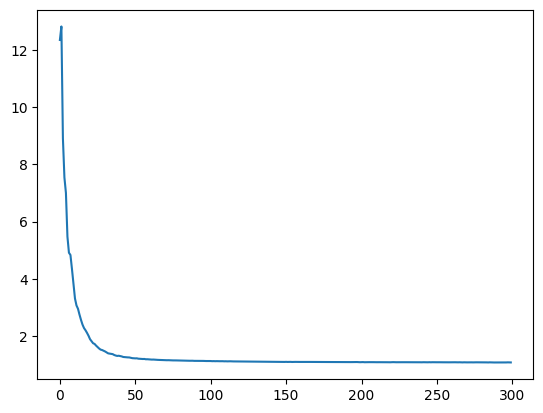

In [12]:
plt.plot(range(epochs),loss_values)

In [17]:
#loss_values[250:]

In [52]:
#model

In [53]:
#Z.shape

In [54]:
#data

In [55]:
#data.edge_index[1]

In [33]:
#g= to_networkx(data)

In [41]:
#g.nodes

In [42]:
#graph.nodes

In [43]:
#g.edges

In [44]:
#graph.edges